In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pygplates
import pygmt

from scipy.stats import median_abs_deviation

from gprm.datasets import Rocks, Reconstructions, Paleogeography
from gprm import PointDistributionOnSphere
from gprm.utils.sphere import groupby_healpix, plot_groups
from gprm.utils.raster import to_anchor_plate

import sys
#sys.path.append('../analysis')
sys.path.append('/Users/simon/OneDrive/Andes_works//python/')
import joyful_geochemistry as joy
import joyful_mapping as joymap
#import time_series as ts

%matplotlib inline
%load_ext autoreload
%autoreload 2


/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [15]:
model_dir = '../luffi/REM_surfaces_csv/'
gc_interpolator_dict = joy.make_gc_interpolator_dict(model_dir)

df = pd.read_csv('../datafiles/geochem_merge_20221026.csv')
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs=4326)
df = joy.compute_ratios(df, long_list=True)

df = joymap.select_orogens(df,gdf=None, 
               orogen_names='Cordilleran', 
               continent_names='South America',
               region=[-100, -50, -60, 20])



In [16]:
region = [-85, -55, -58, 12]

age_max = 2.5
def get_residuals(elevation_estimates, df_filt):
    DEM = pygmt.grdtrack(points=pd.DataFrame(data={'x':df_filt.geometry.x,'y':df_filt.geometry.y}),
                         grid=topo, 
                         newcolname='z', 
                         interpolation='l',
                         no_skip=True)['z']
    return elevation_estimates.sub(DEM, axis=0)#.drop(columns=['bin_latitude', 'bin_longitude', 'geometry'])

topo = pygmt.datasets.load_earth_relief(region='d', resolution='02m', registration='gridline')
topo - pygmt.grdcut(topo, region=region)
topo = pygmt.grdfilter(topo, distance=1, spacing='0.2d', filter='m100')


In [17]:
df_filt = joy.filter_the_database(df, 'luffi', age_min=-1, age_max=age_max)
elevation_estimates = joy.get_elevations(df_filt, gc_interpolator_dict=gc_interpolator_dict)
residuals_luffi = get_residuals(elevation_estimates, df_filt)

df_filt = joy.filter_the_database(df, 'Hu', age_min=-1, age_max=age_max)
elevation_estimates = joy.get_elevations(df_filt, calibration='Hu')
residuals_Hu = get_residuals(elevation_estimates, df_filt)

df_filt = joy.filter_the_database(df, 'FarnerLee', age_min=-1, age_max=age_max)
elevation_estimates = joy.get_elevations(df_filt, calibration='FarnerLee')
residuals_FarnerLee = get_residuals(elevation_estimates, df_filt)


Number of samples after basic filtering 19309
Final number of samples passed = 19309
TODO implement min/max elevation cutoffs


/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:2557: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


Number of samples after basic filtering 19309
Number of samples with 55<=sio2<=70 = 9029
Number of these samples with 1<=mgo<=4 = 6905
Number of these samples with 0.05<=rb/sr<=0.25 = 3816
Final number of samples passed = 3816
TODO implement min/max elevation cutoffs
Number of samples after basic filtering 19309
Number of these samples with a valid sio2 = 15265
Number of these samples with major element sum > 98%= 9942
Final number of samples passed = 9942
TODO implement min/max elevation cutoffs


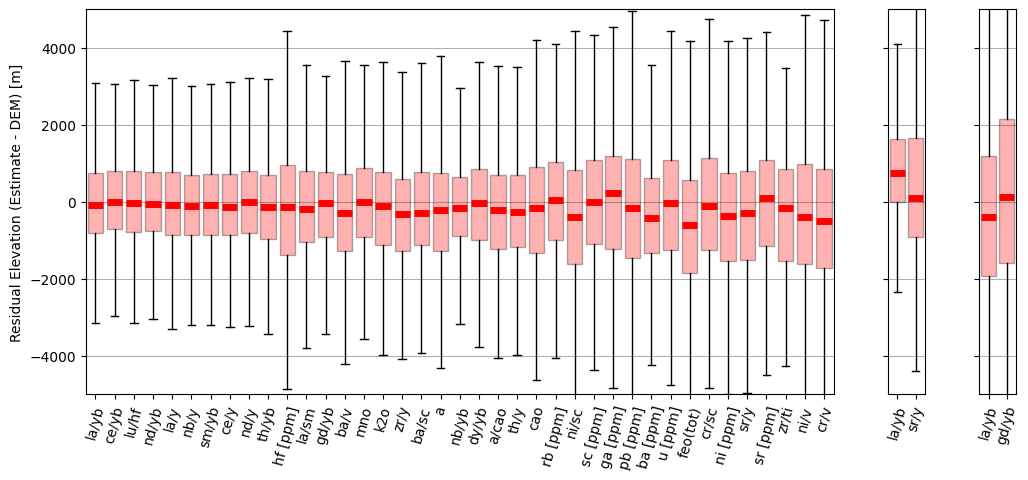

In [18]:
# USE THE BINS INSTEAD OF RAW ESTIMATES...

#stds = df_plot.std()

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(nrows=1, ncols=3, wspace=0.2, hspace=.7, width_ratios=[41,2,2])

for i,resid_df in enumerate([residuals_luffi, residuals_Hu, residuals_FarnerLee]):
    ax=fig.add_subplot(gs[i])
    rs = [v[~np.isnan(v)] for v in resid_df.to_numpy().T]
    ax.boxplot(rs, widths=0.8,
               showfliers=False, 
               patch_artist=True,
               labels=resid_df.columns,
               medianprops={"linewidth": 5,
                 "solid_capstyle": "butt",
                 'color': 'red'},
               boxprops={'facecolor':'red',
                         'alpha':0.3,
                         'edgecolor':'black'},)
    ax.set_ylim(-5000,5000)
    ax.grid(axis='y')
    ax.set_xticklabels([s[:-10].replace('feo_tot','feo(tot)').replace('_ppm',' [ppm]').replace('_','/') for s in resid_df.columns], rotation = 75)
    if i>0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Residual Elevation (Estimate - DEM) [m]')

plt.show()
